# Retail Data Analytics
<br>
This notebook contains the code for training and deploying a retail data analytics model. The goal is to estimate the weekly sales of a store given the input features.
<br>
The data is stored in csv files. There is one csv file containing the training data (train.csv) and one containing the test data (test.csv). Additionally, one can find all feature names in a csv file calls "features_list.csv". 

In [1]:
import pandas as pd
import boto3
import sagemaker

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
# set number of samples that shall be used for visualising test true data and predicted data
NUM_SAMPLES_TEST_VISUALIZATION = 100

Store the standard deviation of weekly sales. This shall then be used to normalize the RMSE value in order to get a better understanding if the RMSE is good or bad. The standard deviation is used in order to also include the outliers.

In [3]:
# the number is extracted from the notebook "1_Data_Exploration.ipynb"
normalization_factor = int(22711.183519)
print(f"Normalization factor: {normalization_factor}")

Normalization factor: 22711


## Load Data to S3

In [53]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

region = boto3.Session().region_name

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

In [54]:
import os
# folder containing the training and test data
data_dir = "data_converted"

# set prefix, a descriptive name for a directory  
prefix = "retail_data_analytics"

# upload all data to S3
train_input = sagemaker_session.upload_data(path=os.path.join(data_dir, "train.csv"), bucket=bucket, key_prefix=prefix)
val_input = sagemaker_session.upload_data(path=os.path.join(data_dir, "val.csv"), bucket=bucket, key_prefix=prefix)
test_input = sagemaker_session.upload_data(path=os.path.join(data_dir, "test.csv"), bucket=bucket, key_prefix=prefix)

In [55]:
# read in test data, assuming it is stored locally
test_data = pd.read_csv(os.path.join(data_dir, "test_with_true_label.csv"), header=None, names=None)

# labels are in the first column
test_y_true = test_data.iloc[:,0]
test_x = test_data.iloc[:,1:]

### Test 
Check if uploading the data to S3 was successfull.

In [37]:
# confirm that data is in S3 bucket
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')

retail_data_analytics/output/sagemaker-xgboost-210108-1006-001-c2f08c45/output/model.tar.gz
retail_data_analytics/output/sagemaker-xgboost-210108-1006-002-2da45dce/output/model.tar.gz
retail_data_analytics/output/sagemaker-xgboost-210108-1006-003-c4ed0ca4/output/model.tar.gz
retail_data_analytics/output/sagemaker-xgboost-210108-1006-004-47fdb693/output/model.tar.gz
retail_data_analytics/output/sagemaker-xgboost-210108-1006-005-b55dc6ce/output/model.tar.gz
retail_data_analytics/output/sagemaker-xgboost-210108-1006-006-7c70af19/output/model.tar.gz
retail_data_analytics/output/sagemaker-xgboost-210108-1006-007-aa81a355/output/model.tar.gz
retail_data_analytics/output/sagemaker-xgboost-210108-1006-008-a486d456/output/model.tar.gz
retail_data_analytics/output/sagemaker-xgboost-210108-1006-009-e516afa5/output/model.tar.gz
retail_data_analytics/output/sagemaker-xgboost-210108-1006-010-3ea89516/output/model.tar.gz
retail_data_analytics/output/sagemaker-xgboost-210108-1006-011-b7eef8cd/output/m

## Train the Benchmark Model

<br>
As benchmark model a linear regression model should be trained. The model is trained using the sklearn library. The training code is located in the file "train_linear_regression.py" within the source folder.

In [11]:
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"
script_path = 'source/train_linear_regression.py'

sklearn_linear_regression = SKLearn(
    entry_point=script_path,
    framework_version=FRAMEWORK_VERSION,
    instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session)

### Train

In [12]:
%%time

# Train the estimator on S3 training data
sklearn_linear_regression.fit({"train": train_input, "validation": val_input})

2021-01-08 08:20:46 Starting - Starting the training job...
2021-01-08 08:21:10 Starting - Launching requested ML instancesProfilerReport-1610094046: InProgress
.........
2021-01-08 08:22:31 Starting - Preparing the instances for training......
2021-01-08 08:23:47 Downloading - Downloading input data
2021-01-08 08:23:47 Training - Downloading the training image...
2021-01-08 08:24:12 Uploading - Uploading generated training model2021-01-08 08:24:02,286 sagemaker-training-toolkit INFO     Imported framework sagemaker_sklearn_container.training
2021-01-08 08:24:02,288 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-01-08 08:24:02,299 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-01-08 08:24:02,702 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-01-08 08:24:05,801 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-01-08 08:24:05,813 sagem

### Deploy

In [13]:
%%time

# deploy the model to create a predictor
predictor_linear_regression = sklearn_linear_regression.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

---------------!CPU times: user 284 ms, sys: 7.72 ms, total: 292 ms
Wall time: 7min 32s


### Evaluate

In [16]:
# compute MSE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

test_y_preds = predictor_linear_regression.predict(test_x.values)
rmse_linear_regression = mean_squared_error(test_y_true, test_y_preds, squared=False)
r2_linear_regression = r2_score(test_y_true, test_y_preds)
print(f"Normalized RMSE: {rmse_linear_regression/normalization_factor}")
print(f"R-Squared Score: {r2_linear_regression}")

Normalized RMSE: 0.94531704841802
R-Squared Score: 0.09128780476379827


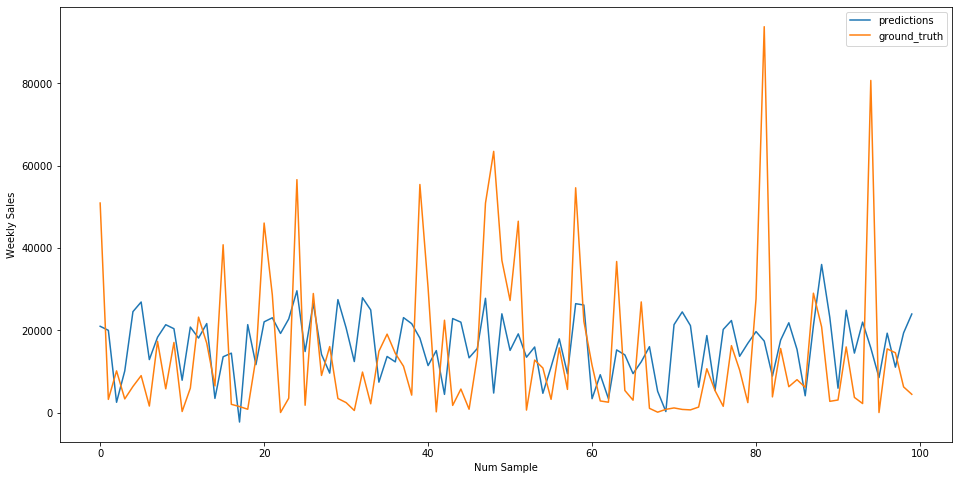

In [17]:
# plot some results
num_samples_test = 100
fig = plt.figure(figsize=(16, 8))
plt.plot(test_y_preds[:NUM_SAMPLES_TEST_VISUALIZATION])
plt.plot(test_y_true[:NUM_SAMPLES_TEST_VISUALIZATION])
plt.legend(("predictions", "ground_truth"))
plt.ylabel("Weekly Sales")
plt.xlabel("Num Sample")
plt.show()

## Train Decision Tree Regressor

The decision tree training is located in the script "train_decision_tree.py". Within the script, bayes optimization for finding the optimal hyperparameters should be performed. The search is executed for n-iter steps and cross validation with n-folds is used in order to find the best performing estimator.

In [18]:
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"
script_path = 'train_decision_tree.py'

hyperparameters = {
    "n-iter": 7,
    "n-folds": 5
}

sklearn_decision_tree = SKLearn(
    entry_point=script_path,
    framework_version=FRAMEWORK_VERSION,
    instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session,
    source_dir = "source",
    hyperparameters = hyperparameters)

### Train

In [19]:
%%time

# Train the estimator on S3 training data
sklearn_decision_tree.fit({"train": train_input, "validation": val_input})

2021-01-08 09:13:24 Starting - Starting the training job...
2021-01-08 09:13:48 Starting - Launching requested ML instancesProfilerReport-1610097203: InProgress
......
2021-01-08 09:14:48 Starting - Preparing the instances for training......
2021-01-08 09:15:49 Downloading - Downloading input data...
2021-01-08 09:16:09 Training - Downloading the training image..2021-01-08 09:16:29,434 sagemaker-training-toolkit INFO     Imported framework sagemaker_sklearn_container.training
2021-01-08 09:16:29,435 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-01-08 09:16:29,445 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-01-08 09:16:29,804 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=5fb074e66b290721252119eae4d0278


2021-01-08 09:16:50 Training - Training image download completed. Training in progress.2021-01-08 09:18:36,815 sagemaker-training-toolkit INFO     Reporting training SUCCESS

2021-01-08 09:18:51 Uploading - Uploading generated training model
2021-01-08 09:18:51 Completed - Training job completed
Training seconds: 185
Billable seconds: 185
CPU times: user 784 ms, sys: 28.9 ms, total: 813 ms
Wall time: 5min 43s


### Deploy

In [20]:
%%time

# deploy the model to create a predictor
predictor_decision_tree = sklearn_decision_tree.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

-------------------!CPU times: user 341 ms, sys: 6.72 ms, total: 348 ms
Wall time: 9min 32s


### Evaluate

In [21]:
# compute MSE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

test_y_preds = predictor_decision_tree.predict(test_x.values)
rmse_decision_tree = mean_squared_error(test_y_true, test_y_preds, squared=False)
r2_decision_tree = r2_score(test_y_true, test_y_preds)
print(f"Normalized RMSE: {rmse_decision_tree/normalization_factor}")
print(f"R-Squared Score: {r2_decision_tree}")

Normalized RMSE: 0.23898157373928974
R-Squared Score: 0.9419235302565172


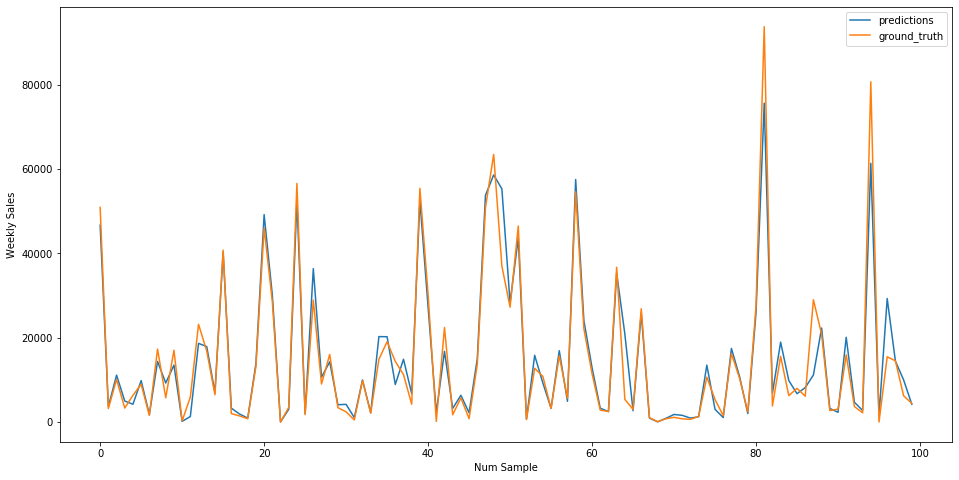

In [22]:
# plot some results
fig = plt.figure(figsize=(16, 8))
plt.plot(test_y_preds[:NUM_SAMPLES_TEST_VISUALIZATION])
plt.plot(test_y_true[:NUM_SAMPLES_TEST_VISUALIZATION])
plt.legend(("predictions", "ground_truth"))
plt.ylabel("Weekly Sales")
plt.xlabel("Num Sample")
plt.show()

## Train Random Forest Regressor

Now a random forest regressor should be trained. Bayes Optimization and cross-validation should again be used in order to find the best performing hyperparameters. The best performing estimator is then stored and deployed.

In [23]:
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"
script_path = 'train_random_forest.py'

hyperparameters = {
    "n-iter": 10,
    "n-folds": 5,
    "n-jobs": -1
}

sklearn_random_forest = SKLearn(
    entry_point=script_path,
    framework_version=FRAMEWORK_VERSION,
    instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session,
    source_dir = "source",
    hyperparameters = hyperparameters)

### Train

In [24]:
%%time

# Train the estimator on S3 training data
sklearn_random_forest.fit({"train": train_input, "validation": val_input})

2021-01-08 09:28:48 Starting - Starting the training job...
2021-01-08 09:29:12 Starting - Launching requested ML instancesProfilerReport-1610098128: InProgress
......
2021-01-08 09:30:12 Starting - Preparing the instances for training......
2021-01-08 09:31:13 Downloading - Downloading input data...
2021-01-08 09:31:47 Training - Training image download completed. Training in progress..2021-01-08 09:31:49,372 sagemaker-training-toolkit INFO     Imported framework sagemaker_sklearn_container.training
2021-01-08 09:31:49,374 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-01-08 09:31:49,383 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-01-08 09:31:50,124 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=35279a

2021-01-08 09:56:22,681 sagemaker-training-toolkit INFO     Reporting training SUCCESS

2021-01-08 09:57:13 Uploading - Uploading generated training model
2021-01-08 09:57:34 Completed - Training job completed
ProfilerReport-1610098128: NoIssuesFound
Training seconds: 1577
Billable seconds: 1577
CPU times: user 4.09 s, sys: 141 ms, total: 4.23 s
Wall time: 29min 11s


### Deploy

In [25]:
%%time

# deploy the model to create a predictor
predictor_random_forest = sklearn_random_forest.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

-----------------!CPU times: user 310 ms, sys: 9.48 ms, total: 320 ms
Wall time: 8min 33s


### Evaluate

In [26]:
# compute MSE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

test_y_preds = predictor_random_forest.predict(test_x.values)
rmse_forest = mean_squared_error(test_y_true, test_y_preds, squared=False)
r2_forest = r2_score(test_y_true, test_y_preds)
print(f"Normalized RMSE: {rmse_forest/normalization_factor}")
print(f"R-Squared Score: {r2_forest}")

Normalized RMSE: 0.24952390371295788
R-Squared Score: 0.936686592416866


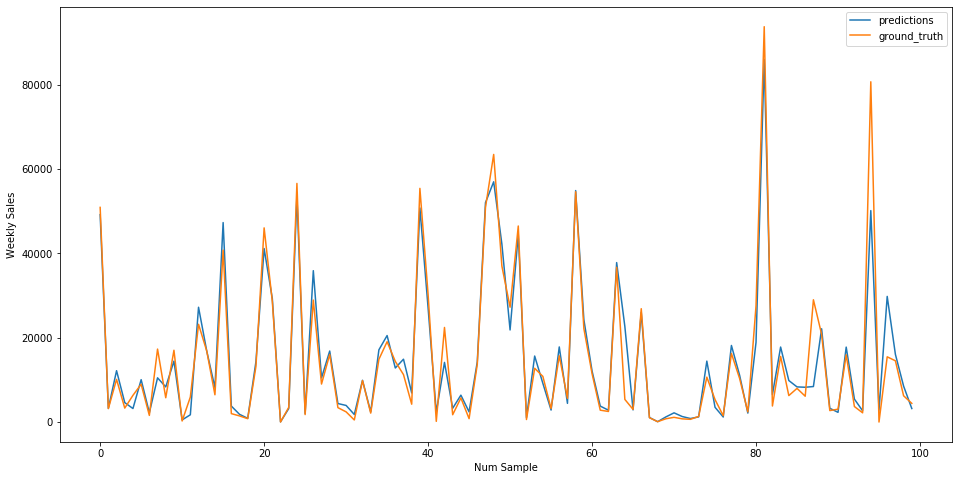

In [27]:
# plot some results
fig = plt.figure(figsize=(16, 8))
plt.plot(test_y_preds[:NUM_SAMPLES_TEST_VISUALIZATION])
plt.plot(test_y_true[:NUM_SAMPLES_TEST_VISUALIZATION])
plt.legend(("predictions", "ground_truth"))
plt.ylabel("Weekly Sales")
plt.xlabel("Num Sample")
plt.show()

## Train XGBoost Regressor

As last estimator a xgboost regressor should be trained. Here, the hyperparameter tuner and the built in xgboost regressor from sagemaker shall be used. The hyperarameter tuner is using bayes optimization again and the best performing estimator should then be deployed.

In [57]:
container = sagemaker.image_uris.retrieve('xgboost', region=region, version="1.0-1")

prefix = "retail_data_analytics"

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sagemaker_session)

In [58]:
# let's use the Hyperparameter Tuner
from sagemaker.tuner import IntegerParameter
from sagemaker.tuner import ContinuousParameter
from sagemaker.tuner import HyperparameterTuner

# Define exploration boundaries (default suggested values from Amazon SageMaker Documentation)
hyperparameter_ranges = {
    'alpha': ContinuousParameter(0, 1000, scaling_type="Auto"),
    'eta': ContinuousParameter(0.1, 0.5, scaling_type='Logarithmic'),
    'gamma':ContinuousParameter(0, 5, scaling_type='Auto'),
    'lambda': ContinuousParameter(0,100,scaling_type='Auto'),
    'max_delta_step': IntegerParameter(0,10,scaling_type='Auto'),
    'max_depth': IntegerParameter(0,10,scaling_type='Auto'),
    'min_child_weight': ContinuousParameter(0,10,scaling_type='Auto'),
    'subsample': ContinuousParameter(0.5,1,scaling_type='Logarithmic'),
    'num_round': IntegerParameter(50,1000,scaling_type='Auto')
}


In [59]:
tuner_log = HyperparameterTuner(xgb,
                                objective_metric_name="validation:rmse",
                                objective_type='Minimize',
                                hyperparameter_ranges=hyperparameter_ranges,
                                max_jobs=20,
                                max_parallel_jobs=4,
                                strategy='Bayesian')

### Train

In [60]:
from sagemaker.inputs import TrainingInput

train_channel = TrainingInput(train_input, content_type='text/csv')
valid_channel = TrainingInput(val_input, content_type='text/csv')

data_channels = {'train': train_channel, 'validation': valid_channel}

In [ ]:
%%time
# Starts the hyperparameter tuning job
tuner_log.fit(inputs=data_channels,  logs=True)

...................................................................................................................................................................................

### Deploy

In [ ]:
# Create a new estimator object attached to the best training job found during hyperparameter tuning

xgb_attached = sagemaker.estimator.Estimator.attach(tuner_log.best_training_job())

In [ ]:
xgb_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [ ]:
# Start the transform job. Make sure to specify the content type and the split type of the test data.
xgb_transformer.transform(test_input, content_type='text/csv', split_type='Line')

### Evaluate

In [ ]:
# copy the predictions file from s3 to this notebook
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

In [ ]:
# compute MSE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

test_y_preds = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
rmse_xgboost = mean_squared_error(test_y_true, test_y_preds, squared=False)
r2_xgboost = r2_score(test_y_true, test_y_preds)
print(f"Normalized RMSE: {rmse_xgboost/normalization_factor}")
print(f"R-Squared Score: {r2_xgboost}")

In [ ]:
# plot some results
fig = plt.figure(figsize=(16, 8))
plt.plot(test_y_preds[:NUM_SAMPLES_TEST_VISUALIZATION])
plt.plot(test_y_true[:NUM_SAMPLES_TEST_VISUALIZATION])
plt.legend(("predictions", "ground_truth"))
plt.ylabel("Weekly Sales")
plt.xlabel("Num Sample")
plt.show()

## Clean Up Resources

In [ ]:
predictor_linear_regression.delete_endpoint()

In [ ]:
predictor_linear_regression_standardized.delete_endpoint()

In [ ]:
predictor_decision_tree.delete_endpoint()

In [ ]:
predictor_random_forest.delete_endpoint()

In [ ]:
predictor_xgboost.delete_endpoint()

In [52]:
bucket_to_delete = boto3.resource('s3').Bucket(bucket)
bucket_to_delete.objects.all().delete()

[{'ResponseMetadata': {'RequestId': '4B3965092378F3C4',
   'HostId': 'kcJQnzHob8owgspB6njbuaWr4WefGMbgsDbODjDEOsPd+jkjK7lHoBIDuL3KPhixKi19Tc4TmIk=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'kcJQnzHob8owgspB6njbuaWr4WefGMbgsDbODjDEOsPd+jkjK7lHoBIDuL3KPhixKi19Tc4TmIk=',
    'x-amz-request-id': '4B3965092378F3C4',
    'date': 'Fri, 08 Jan 2021 13:11:13 GMT',
    'connection': 'close',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'sagemaker-scikit-learn-2021-01-08-09-13-23-989/rule-output/ProfilerReport-1610097203/profiler-output/profiler-reports/MaxInitializationTime.json'},
   {'Key': 'sagemaker-scikit-learn-2021-01-08-09-28-48-313/profiler-output/system/incremental/2021010809/1610099580.algo-1.json'},
   {'Key': 'sagemaker-scikit-learn-2021-01-08-08-20-46-212/rule-output/ProfilerReport-1610094046/profiler-output/profiler-reports/GPUMemoryIncrease.json'},
   {'Key': '